# 데이콘 Basic 따릉이 대여량 예측 경진대회
2018~2020년 4,5,6월 기상 데이터, 2021년 4,5,6월 대여량 예측
https://dacon.io/competitions/official/235837/overview/description
https://dacon.io/competitions/official/235837/codeshare/3714?page=1&dtype=recent

시각화 참고: https://dacon.io/competitions/official/235837/codeshare/3742?page=1&dtype=recent

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime 

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# rawdata

In [3]:
train.info() #날씨 데이터로 대여량 예측, 결측값은 없음
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 21.5+ KB


,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,202.750967,2.288256,0.100963,2.480963,56.745491,13.795249,23.384733,16.878103,59574.978022
std,56.659232,0.961775,0.203193,0.884397,12.351268,5.107711,5.204605,16.643772,27659.575774
min,57.047000,1.000000,0.000000,0.753000,24.831000,1.938000,9.895000,0.000000,1037.000000
25%,171.541000,1.405000,0.000000,1.820000,47.196000,9.938000,19.842000,4.054000,36761.000000
50%,209.774000,2.167000,0.000000,2.411000,55.845000,14.375000,24.158000,12.162000,63032.000000
75%,238.412000,3.000000,0.088000,2.924000,66.419000,18.000000,27.526000,22.973000,81515.000000
max,321.622000,4.000000,1.000000,5.607000,88.885000,22.312000,33.421000,82.162000,110377.000000


In [4]:
train.head(3)

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.0,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.0,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.0,2.690,74.879,10.312,15.316,19.113,26817


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  91 non-null     object 
 1   wind_direction             91 non-null     float64
 2   sky_condition              91 non-null     float64
 3   precipitation_form         91 non-null     float64
 4   wind_speed                 91 non-null     float64
 5   humidity                   91 non-null     float64
 6   low_temp                   91 non-null     float64
 7   high_temp                  91 non-null     float64
 8   Precipitation_Probability  91 non-null     float64
dtypes: float64(8), object(1)
memory usage: 6.5+ KB


In [6]:
for dataset in (train, test):
    dataset['date_time'] = dataset.apply(lambda x: datetime.strptime(x['date_time'], '%Y-%m-%d'), axis=1)
    dataset['year'] = dataset.apply(lambda x: x['date_time'].year, axis=1)
    dataset['month'] = dataset.apply(lambda x: x['date_time'].month, axis=1)
    dataset["day"] = dataset["date_time"].dt.day
    dataset["weekday"] = dataset["date_time"].dt.weekday
    dataset['monthday'] = dataset.apply(lambda x: (str(x['month'])+'-'+str(x['day'])), axis=1)
    dataset["temp_diff"] = dataset["high_temp"]-dataset["low_temp"] #일교차
    dataset["med_temp"] = dataset.apply(lambda x: (x["high_temp"]+x["low_temp"])/2, axis=1)
    dataset['discomf'] = dataset.apply(lambda x: (x['med_temp']*1.8)-((0.55*(1-(x['humidity'])/100))*(x['med_temp']*1.8-26))+32, axis=1)

In [7]:
train = train[['date_time', 'year', 'month', 'day', 'weekday', 'monthday', 
              'wind_direction', 'wind_speed', 'sky_condition', 
              'precipitation_form','Precipitation_Probability', 
              'humidity', 'low_temp', 'high_temp', 'temp_diff', 'med_temp', 'discomf', 
              'number_of_rentals']]
test = test[['date_time', 'year', 'month', 'day', 'weekday', 'monthday', 
              'wind_direction', 'wind_speed', 'sky_condition', 
              'precipitation_form','Precipitation_Probability', 
              'humidity', 'low_temp', 'high_temp', 'temp_diff', 'med_temp', 'discomf']]              
train.head(2)

,date_time,year,month,day,weekday,monthday,wind_direction,wind_speed,sky_condition,precipitation_form,Precipitation_Probability,humidity,low_temp,high_temp,temp_diff,med_temp,discomf,number_of_rentals
0,2018-04-01,2018,4,1,6,4-1,207.500,3.050,4.00,0.0,30.0,75.000,12.600,21.0,8.400,16.800,61.657000,22994
1,2018-04-02,2018,4,2,0,4-2,208.317,3.278,2.95,0.0,19.5,69.833,12.812,19.0,6.188,15.906,60.194302,28139


In [8]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

# EDA

[Text(0.5, 0, 'weekday'),
 Text(0, 0.5, 'rentals'),
 Text(0.5, 1.0, 'weekday-ly rentals')]

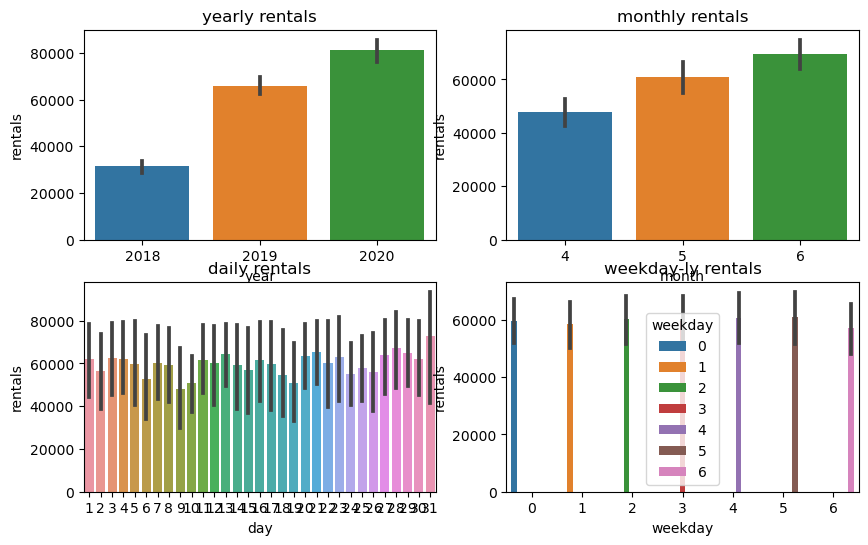

In [9]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(10,6)

sns.barplot(data=train, x="year", y="number_of_rentals", ax=ax1)
sns.barplot(data=train, x="month", y="number_of_rentals", ax=ax2)
sns.barplot(data=train, x="day", y="number_of_rentals", ax=ax3)
sns.barplot(data=train, x="weekday", y="number_of_rentals", hue = "weekday", ax=ax4,)

ax1.set(ylabel='rentals',xlabel='year', title="yearly rentals",)
ax2.set(xlabel='month',ylabel='rentals',title="monthly rentals")
ax3.set(xlabel='day',ylabel='rentals',title="daily rentals")
ax4.set(xlabel='weekday',ylabel='rentals', title="weekday-ly rentals")

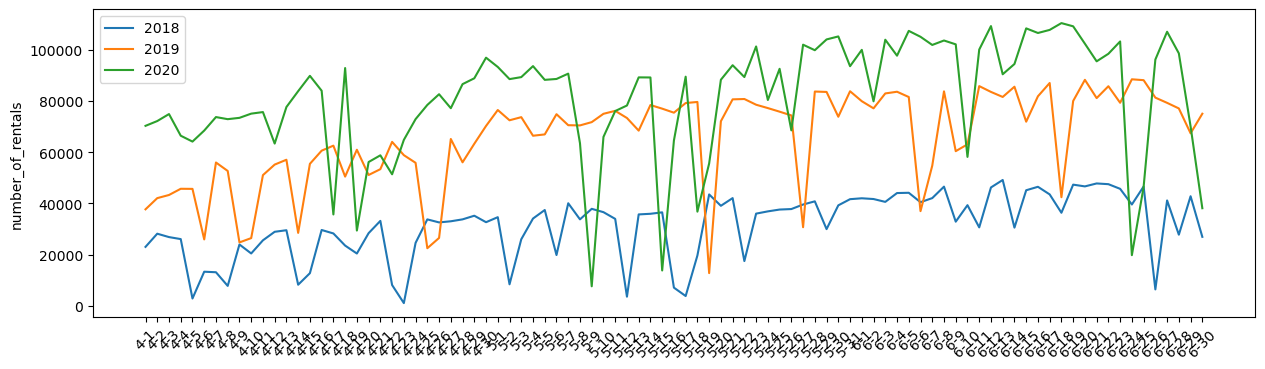

In [10]:
yr=[2018, 2019, 2020]

plt.figure(figsize=(15, 4))
for y in yr:
    plt.plot('monthday', 'number_of_rentals', data=train[train['year']==y])
plt.ylabel('number_of_rentals')
plt.xticks(rotation=45)
plt.legend(yr)
plt.show()

C:\Users\junel\AppData\Local\Temp\ipykernel_20032\139423547.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ym=train.groupby(['year','month'],as_index=False).mean()


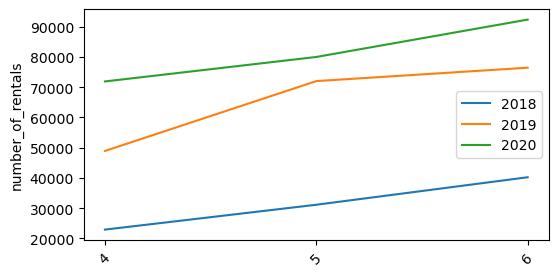

In [11]:
ym=train.groupby(['year','month'],as_index=False).mean()
yr=[2018, 2019, 2020]

plt.figure(figsize=(6,3))
for y in yr:
    plt.plot('month', 'number_of_rentals',data=ym[ym['year']==y])
plt.ylabel('number_of_rentals')
plt.xticks([4,5,6],rotation=45)
plt.legend(yr)
plt.show()

: 해가 갈수록, 여름에 가까워질수록 전반적인 렌탈이 증가하고 있음

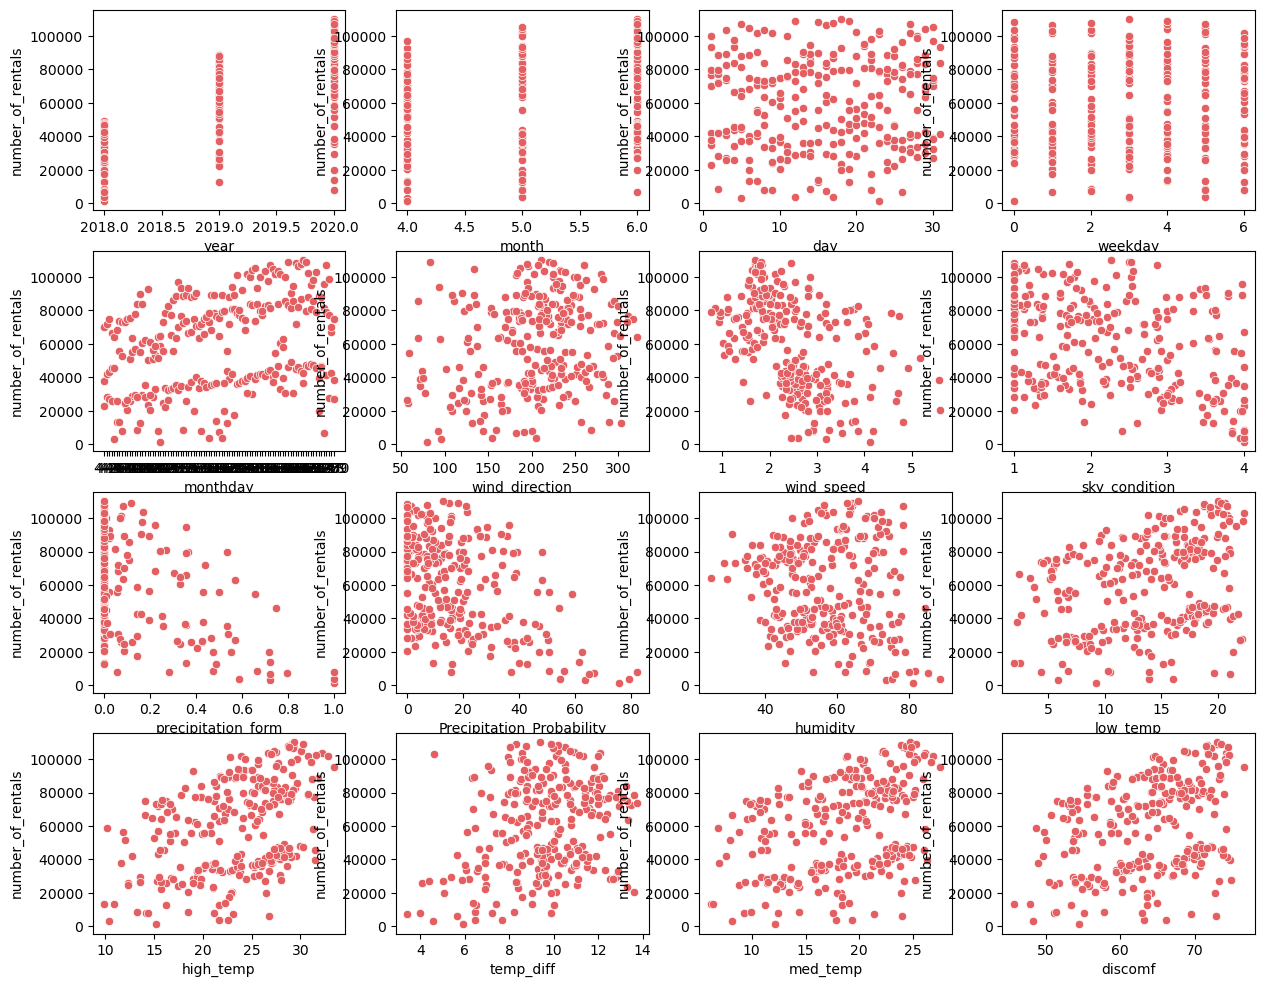

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(15,12))
cl = train.columns
row=0
col=0
for i in cl[1:-1]:
    sns.scatterplot(data=train, x=i, y='number_of_rentals', ax=axes[row, col], color='#e35f62')
    col+=1
    if col==4:
        col=0
        row+=1

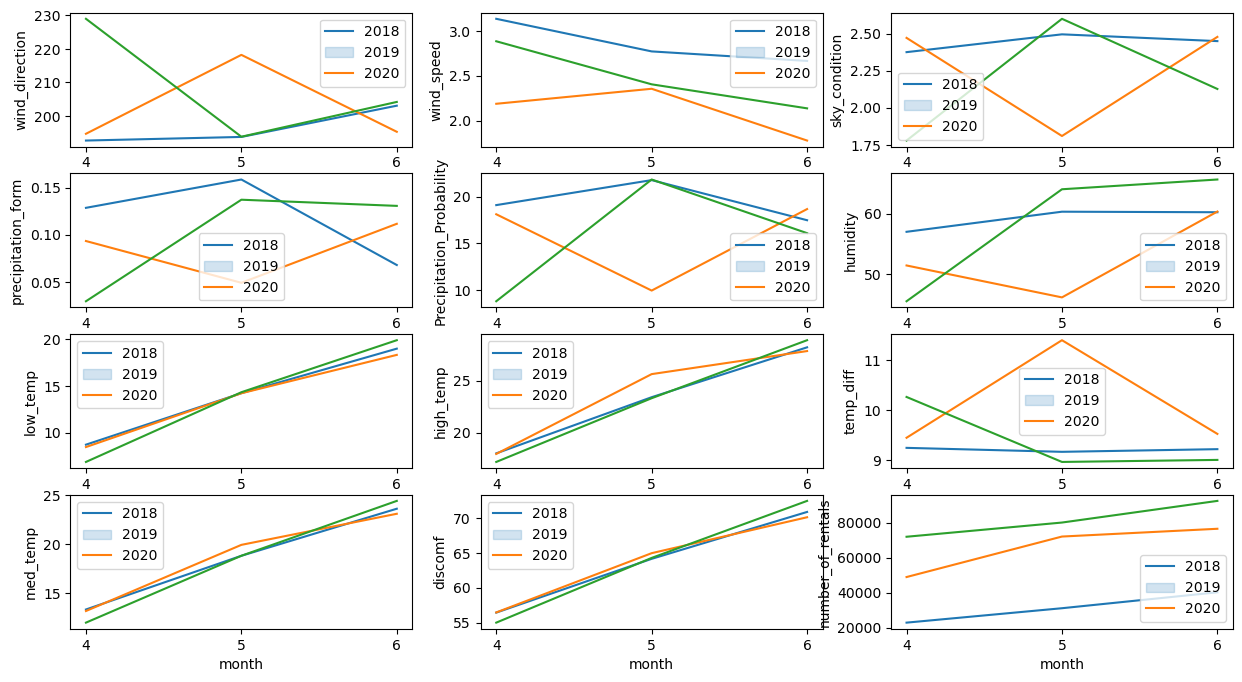

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(15,8))
row=0
col=0
for i in ['wind_direction', 'wind_speed',
       'sky_condition', 'precipitation_form', 'Precipitation_Probability',
       'humidity', 'low_temp', 'high_temp', 'temp_diff', 'med_temp', 'discomf',
       'number_of_rentals']:
    for y in yr:
        sns.lineplot(x='month', y=i, data=ym[ym['year']==y], ax=axes[row, col])
        axes[row, col].set(ylabel=i)
        axes[row, col].set_xticks([4,5,6])
        axes[row, col].legend(yr)

    col+=1
    if col==3:
        col=0
        row+=1

plt.show()

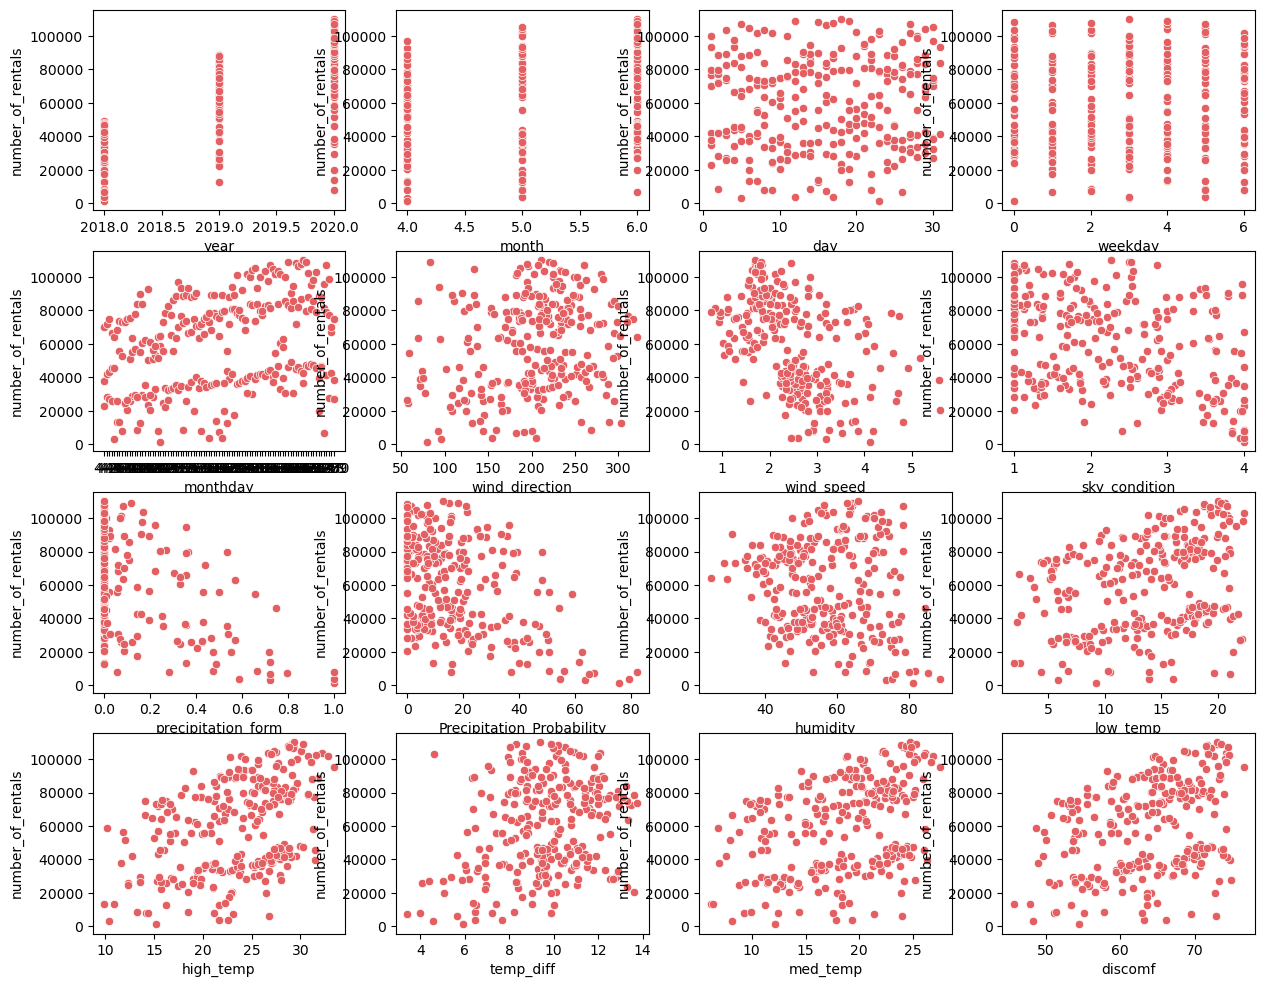

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(15,12))
cl = train.columns
row=0
col=0
for i in cl[1:-1]:
    sns.scatterplot(data=train, x=i, y='number_of_rentals', ax=axes[row, col], color='#e35f62')
    col+=1
    if col==4:
        col=0
        row+=1

: 기온 외에는 경향성이 뚜렷하게 보이지는 않음

C:\Users\junel\AppData\Local\Temp\ipykernel_20032\3549214748.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatt = train.corr()


<AxesSubplot: >

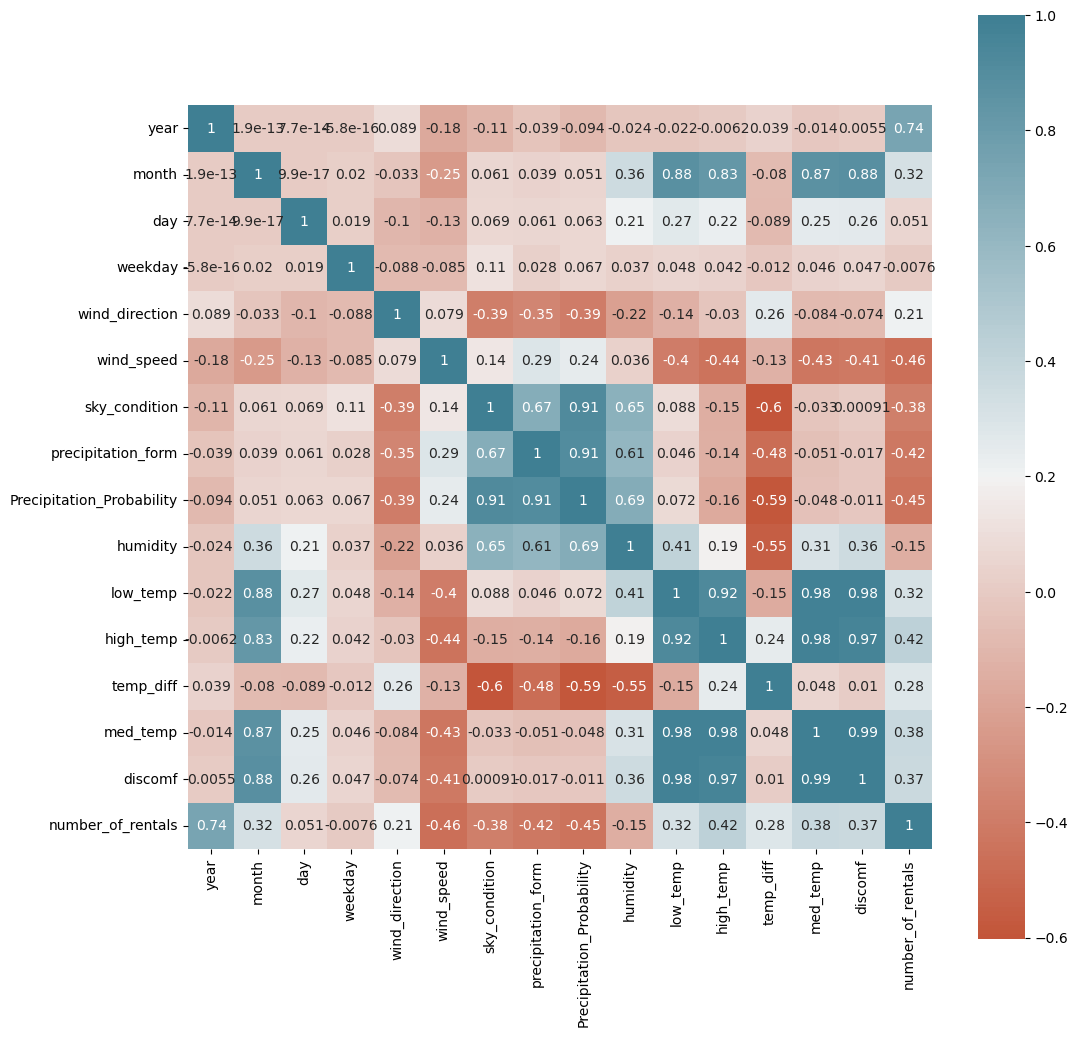

In [15]:
corrMatt = train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
sns.heatmap(corrMatt,annot=True, square=True, cmap =sns.diverging_palette(20, 220, n=200))

여름에 가까워질수록 기온 상관성 뚜렷.
강수 관련과 sky condition

<AxesSubplot: xlabel='discomf', ylabel='number_of_rentals'>

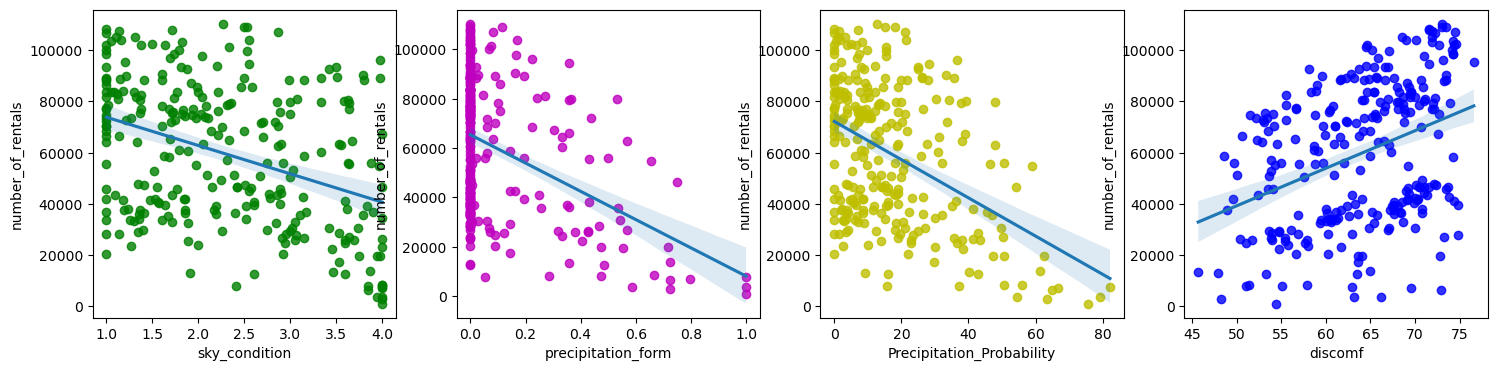

In [16]:
figure, ((ax1,ax2,ax3,ax4)) = plt.subplots(nrows=1, ncols=4)
figure.set_size_inches(18,4)
sns.regplot(data=train, x='sky_condition', y='number_of_rentals', scatter_kws={'color': 'g'}, ax=ax1)
sns.regplot(data=train, x='precipitation_form', y='number_of_rentals', scatter_kws={'color':'m'}, ax=ax2)
sns.regplot(data=train, x='Precipitation_Probability', y='number_of_rentals',scatter_kws={'color':'y'},ax=ax3)
sns.regplot(data=train, x='discomf', y='number_of_rentals',scatter_kws={'color':'b'},ax=ax4)

: 맑을수록, 비가 안 올수록, 강수확률이 낮을수록 불쾌지수 높아질수록 (?) 많이 대여되는 모습 

# 시계열 데이터 처리

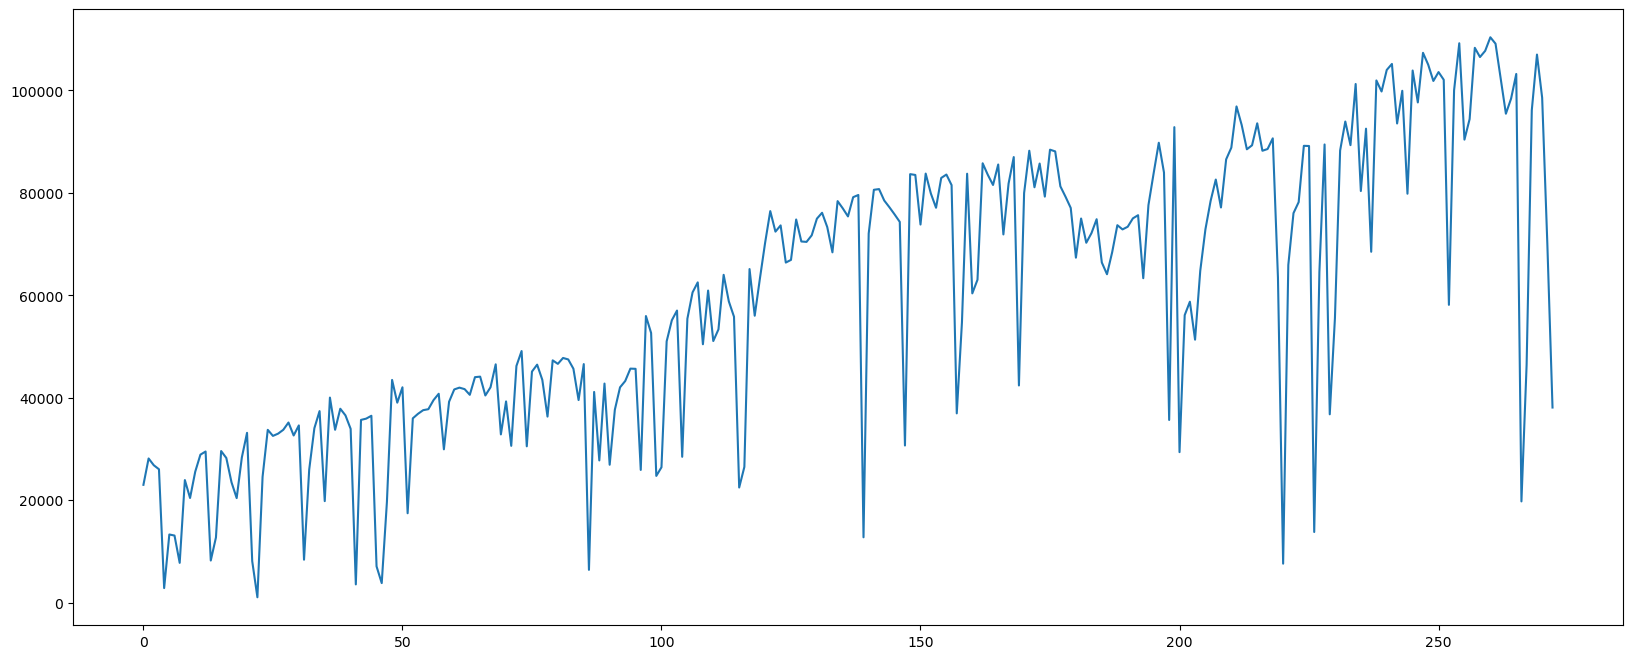

In [17]:
plt.figure(figsize=(20,8))
plt.plot(train.number_of_rentals)
plt.show()

<Figure size 640x480 with 0 Axes>

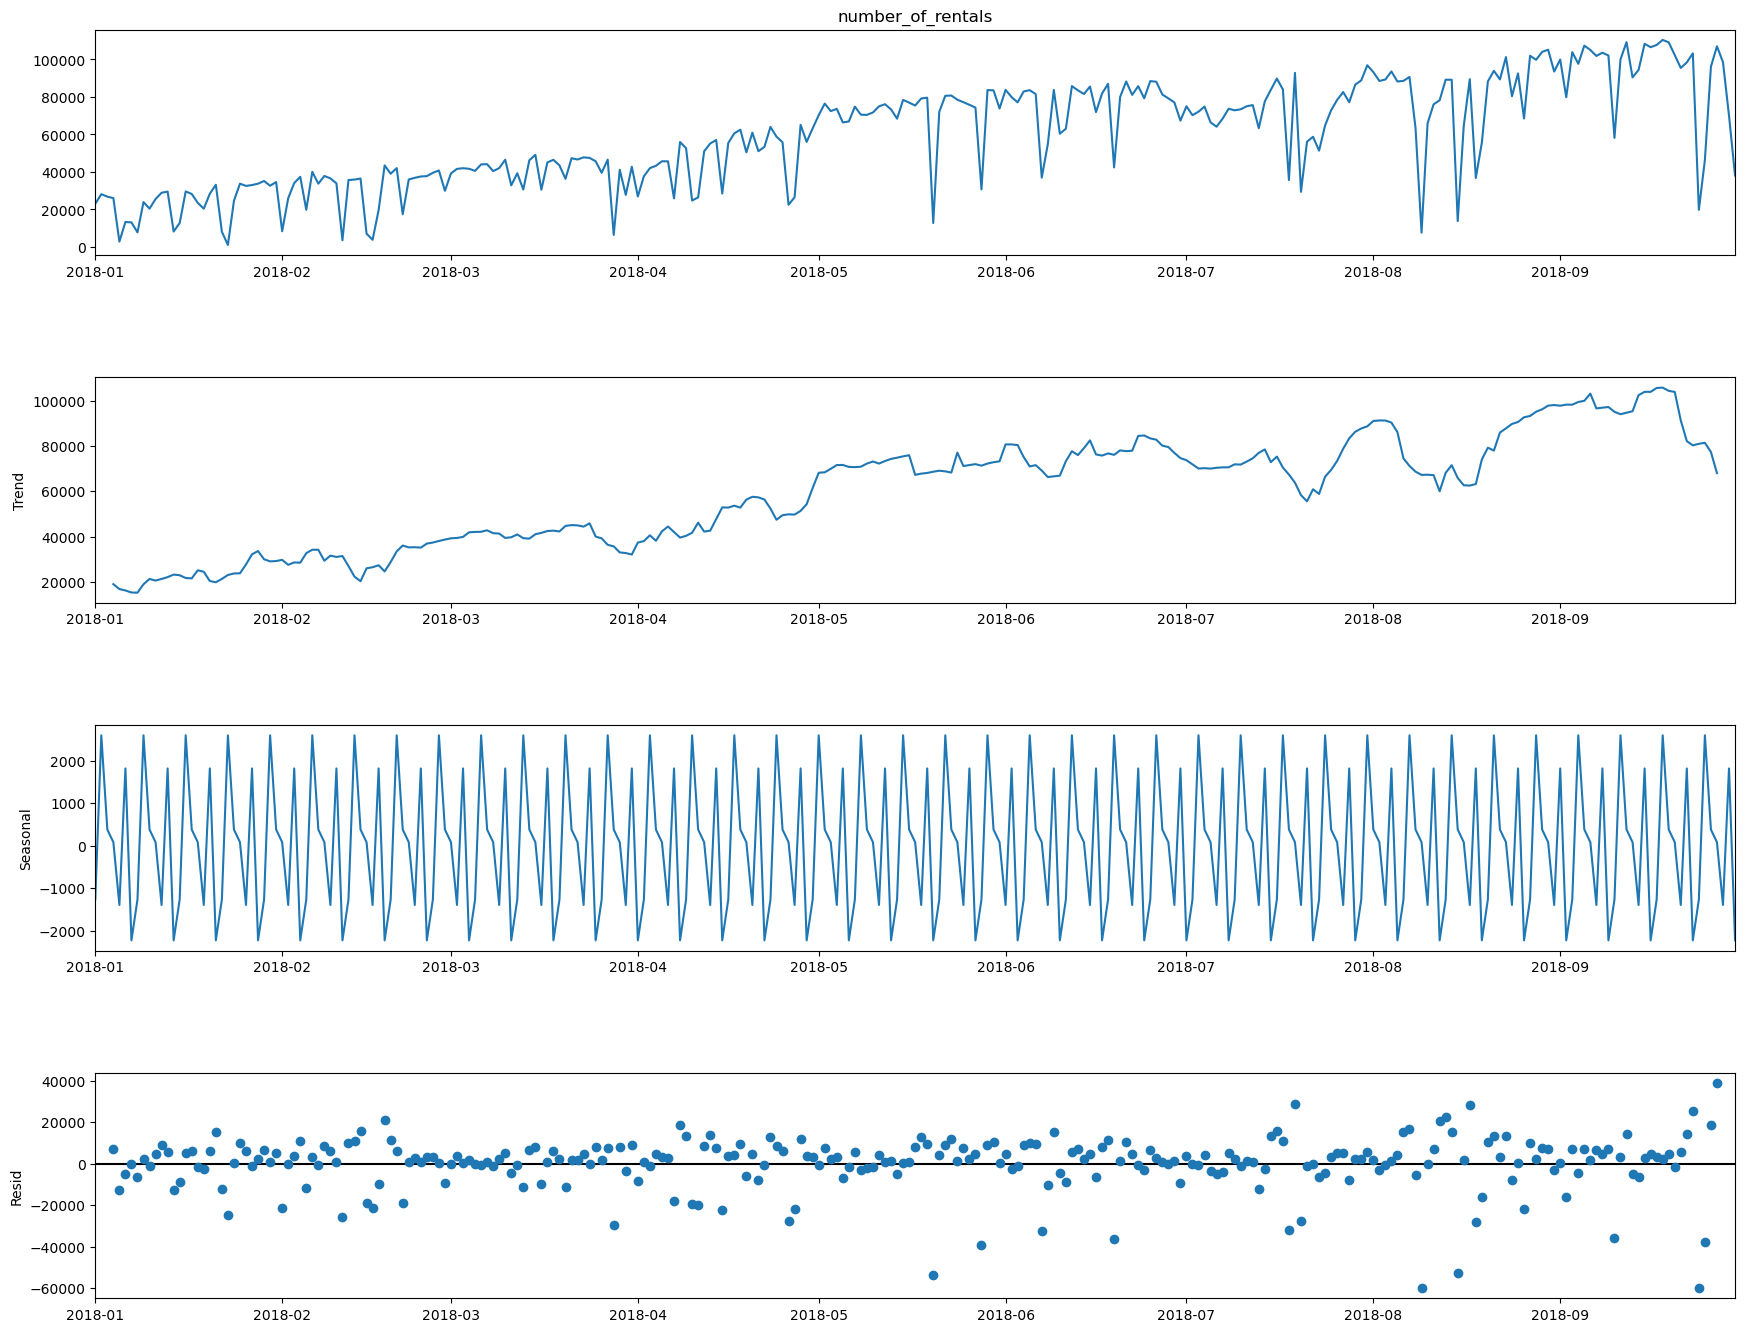

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts=train.loc[:,['number_of_rentals']]
ts['fakedate']=pd.date_range('2018-1-1', periods=273, freq='D')
ts.index = ts.fakedate

ts=ts.drop('fakedate',axis=1)

result = seasonal_decompose(ts['number_of_rentals'], model='additive')
fig = plt.figure()
fig=result.plot()
fig.set_size_inches(20,15)
plt.show()

정상성이 의심되고, 주기성도 보임

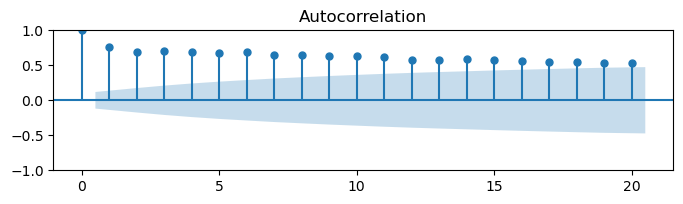

In [19]:
import statsmodels.api as sm

fig = plt.figure(figsize=(8,4))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1)

In [20]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(ts)
print('ADF Statistics: ', result[0])
print('p-value: ',result[1]) #0.05이상이므로 정상성 만족X 

ADF Statistics:  -2.0578539742664974
p-value:  0.2617957538971578


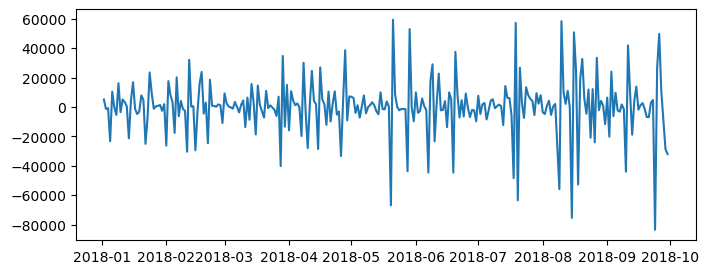

In [21]:
#1차 차분
ts_diff = ts-ts.shift()
plt.figure(figsize=(8,3))
plt.plot(ts_diff)
plt.show()

In [22]:
result=adfuller(ts_diff[1:])
print('ADF Statistics: ', result[0])
print('p-value: ',result[1]) #정상성 만족

ADF Statistics:  -9.838978628081879
p-value:  4.8099138828179434e-17


c:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


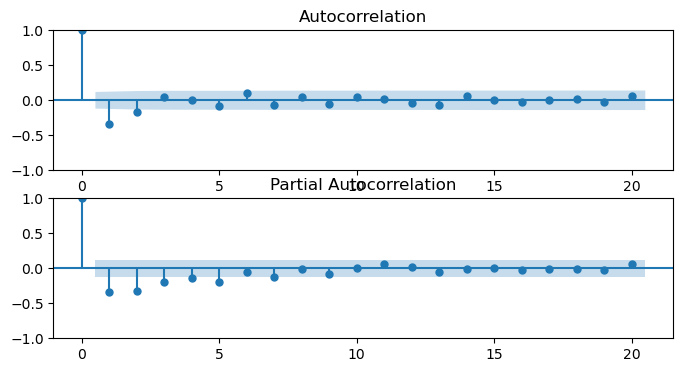

In [23]:
fig = plt.figure(figsize=(8,4))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(ts_diff[1:], lags=20, ax=ax2)

lag 2 이후부터 수렴하므로 ARIMA(2,1,2) 시도

# ARIMA 완전 별로

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm

In [25]:
p = range(0,3)
d = range(1,2)
q = range(0,6)

pdq = list(itertools.product(p,d,q))

aic = []
params = []

with tqdm(total = len(pdq)) as pg:
    for i in pdq:
        pg.update(1)
        try:
            model = SARIMAX(ts["number_of_rentals"], order=(i))
            model_fit = model.fit(disp=0)
            aic.append(round(model_fit.aic,2))
            params.append((i))
        except:
            continue

  0%|          | 0/18 [00:00<?, ?it/s]c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 17%|█▋        | 3/18 [00:00<00:00, 28.19it/s]c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency

In [26]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = ARIMA(train["number_of_rentals"], order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      number_of_rentals   No. Observations:                  273
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3013.029
Date:                Fri, 27 Jan 2023   AIC                           6032.057
Time:                        10:00:02   BIC                           6042.874
Sample:                             0   HQIC                          6036.400
                                - 273                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6423      0.056    -11.516      0.000      -0.752      -0.533
ma.L2         -0.1983      0.050     -3.932      0.000      -0.297      -0.099
sigma2      2.544e+08   4.93e-11   5.16e+18      0.000    2.54e+08    2.54e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               728.87
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               3.82   Skew:                            -2.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.66e+33. Standard errors may be unstable.
"""

c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


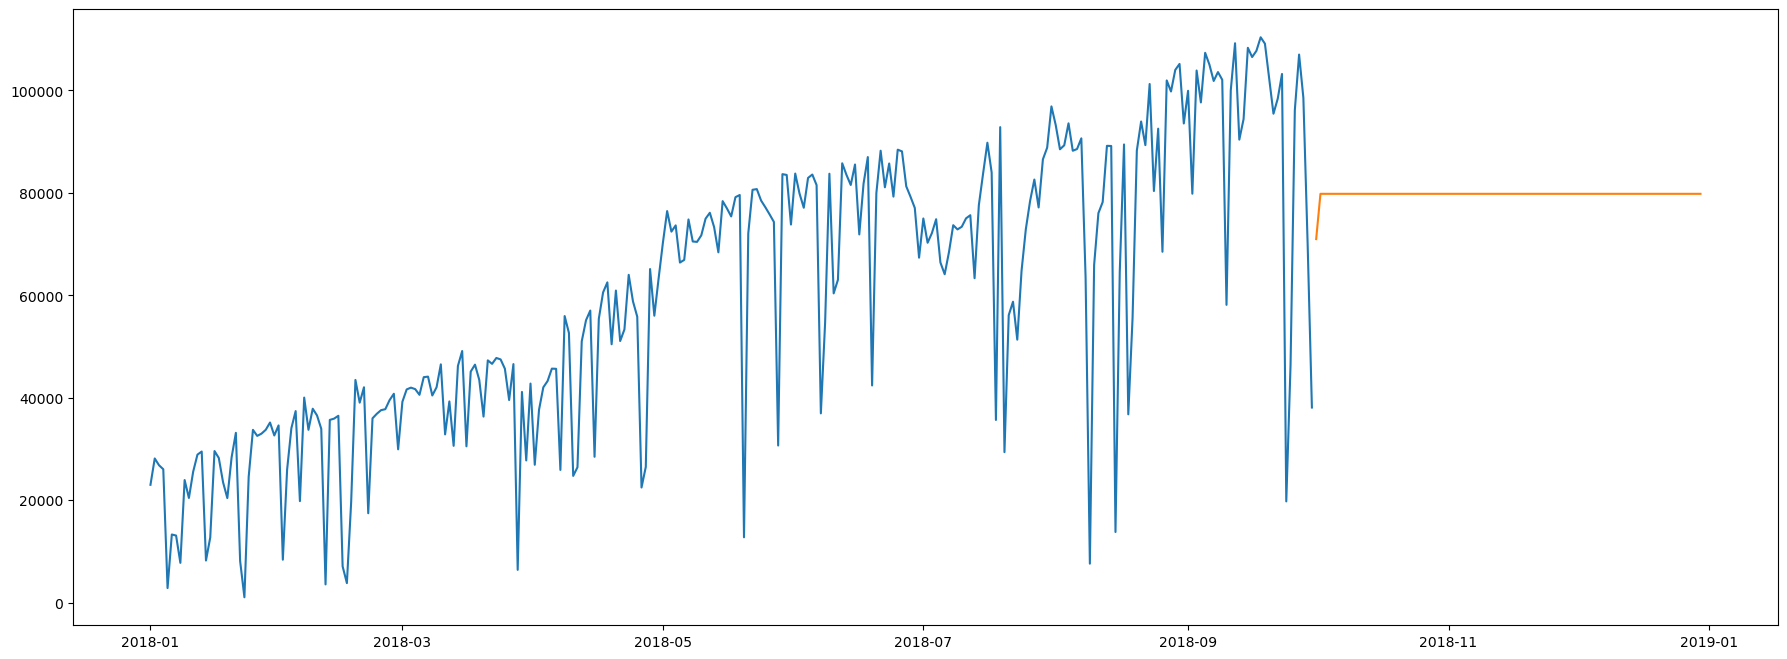

In [27]:
model = ARIMA(ts, order=(0, 1, 2))
model_fit = model.fit()

start_idx=datetime(2018,10,1)
end_idx=datetime(2018,12,30)
forecast = model_fit.predict(start=start_idx, end=end_idx, type='levels')

plt.figure(figsize=(22,8))
plt.plot('number_of_rentals', data=ts, label='original')
plt.plot(forecast, label="predicted")
plt.show()

# SARIMAX (m = 7) : NMAE=0.1624851686378917

In [28]:
p = range(0,3)
d = range(1,2)
q = range(0,6)
m = 7
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1], x[2], m) for x in list(itertools.product(p,d,q))]

aic = []
params = []

with tqdm(total = len(pdq) * len(seasonal_pdq)) as pg:
    for i in pdq:
        for j in seasonal_pdq:
            pg.update(1)
            try:
                model = SARIMAX(ts, order=(i), season_order = (j))
                model_fit = model.fit(disp=0)
                aic.append(round(model_fit.aic,2))
                params.append((i,j))
            except:
                continue

  0%|          | 0/324 [00:00<?, ?it/s]c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, fr

In [29]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = SARIMAX(ts, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit(disp=0)
model_opt_fit.summary()

c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  number_of_rentals   No. Observations:                  273
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 7)   Log Likelihood               -3021.024
Date:                            Fri, 27 Jan 2023   AIC                           6048.048
Time:                                    10:01:00   BIC                           6058.787
Sample:                                01-01-2018   HQIC                          6052.363
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7810      0.057    -13.593      0.000      -0.894      -0.668
ma.L2         -0.2105      0.066     -3.200      0.001      -0.339      -0.082
sigma2      5.164e+08   1.16e-11   4.46e+19      0.000    5.16e+08    5.16e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                81.09
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.34e+35. Standard errors may be unstable.
"""

c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


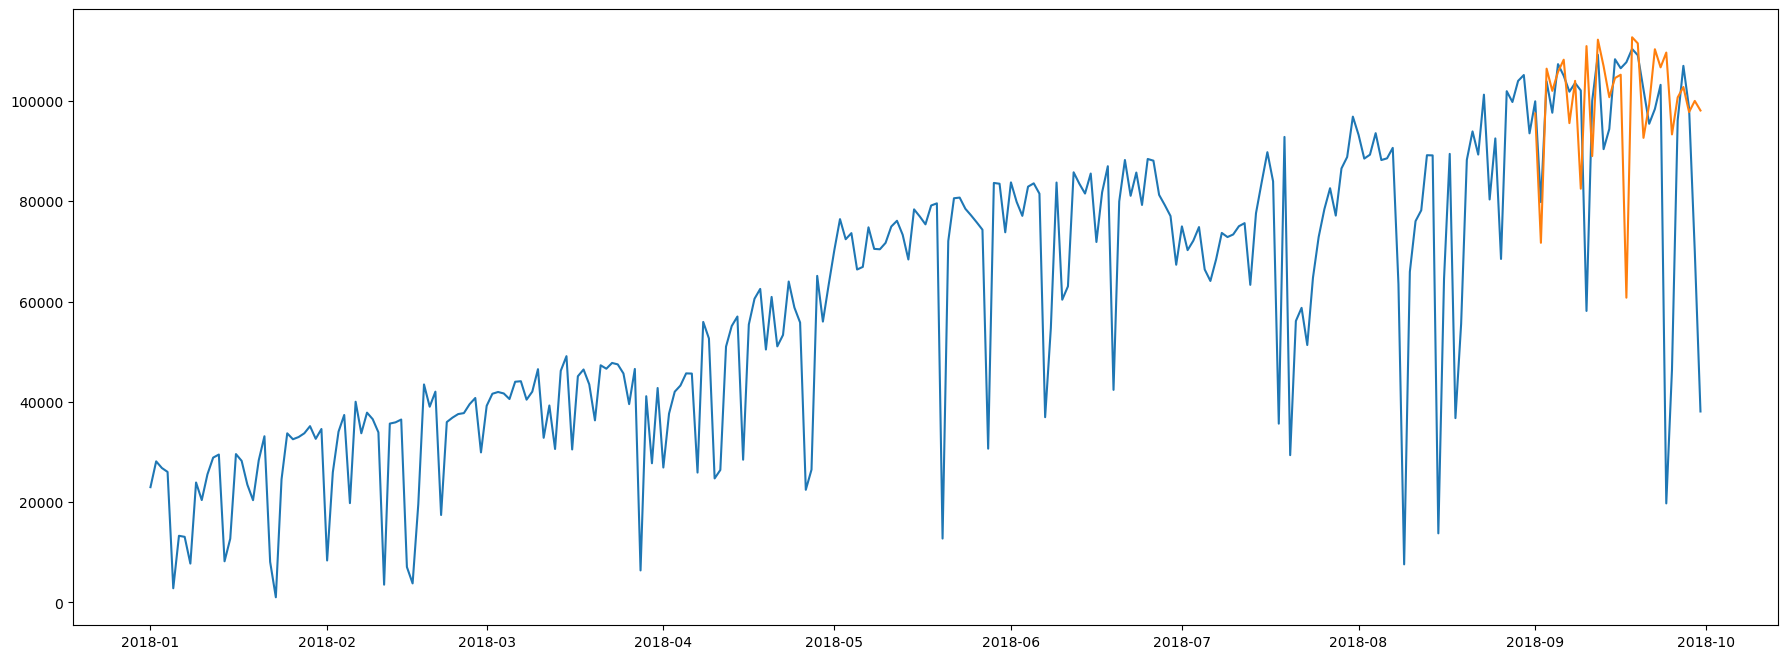

In [30]:
model = SARIMAX(ts, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_fit = model.fit(disp=0)

start_idx=datetime(2018,9,1)
end_idx=datetime(2018,9,30)
forecast = model_fit.predict(start=start_idx, end=end_idx, type='levels')

plt.figure(figsize=(22,8))
plt.plot('number_of_rentals', data=ts, label='original')
plt.plot(forecast, label="predicted")
plt.show()

In [31]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
NMAE(forecast, ts.iloc[-30:]['number_of_rentals'])

0.1624851686378917

In [33]:
MAPEval(forecast, ts.iloc[-30:]['number_of_rentals'])

34.226122009097615

# feature engineering

In [34]:
train.columns

Index(['date_time', 'year', 'month', 'day', 'weekday', 'monthday',
       'wind_direction', 'wind_speed', 'sky_condition', 'precipitation_form',
       'Precipitation_Probability', 'humidity', 'low_temp', 'high_temp',
       'temp_diff', 'med_temp', 'discomf', 'number_of_rentals'],
      dtype='object')

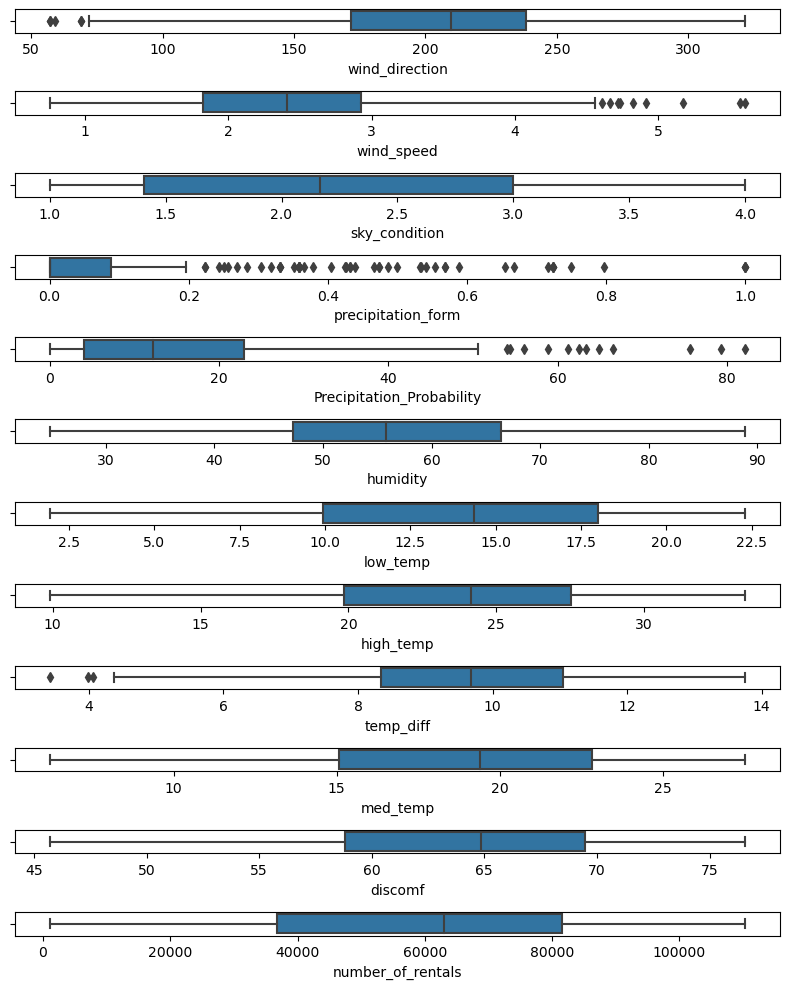

In [35]:
# boxplot으로 이상치 확인
fig, axes = plt.subplots(12,1, figsize = (8, 10))
row=0
for i in ['wind_direction', 'wind_speed', 'sky_condition', 'precipitation_form',
       'Precipitation_Probability', 'humidity', 'low_temp', 'high_temp',
       'temp_diff', 'med_temp', 'discomf', 'number_of_rentals']:
    sns.boxplot(data = train, x = i, ax = axes[row])
    row+=1
plt.tight_layout()
plt.show()

In [36]:
# IQR 기준 이상치 행 확인
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers

In [37]:
Outliers_to_drop = detect_outliers(train, 2, ['wind_direction', 'wind_speed', 'sky_condition', 'precipitation_form',
       'Precipitation_Probability', 'humidity', 'low_temp', 'high_temp',
       'temp_diff', 'med_temp', 'discomf', 'number_of_rentals'])
print(len(Outliers_to_drop))
train.iloc[Outliers_to_drop]

2


,date_time,year,month,day,weekday,monthday,wind_direction,wind_speed,sky_condition,precipitation_form,Precipitation_Probability,humidity,low_temp,high_temp,temp_diff,med_temp,discomf,number_of_rentals
158,2019-06-07,2019,6,7,4,6-7,58.986,4.609,3.966,0.655,58.851,72.027,17.438,26.211,8.773,21.8245,69.240321,54701
45,2018-05-16,2018,5,16,2,5-16,191.108,2.815,4.000,0.797,66.554,85.405,19.688,23.105,3.417,21.3965,69.509194,7072


In [38]:
train1 = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
train1.shape

(271, 18)

-0.09838904639443165


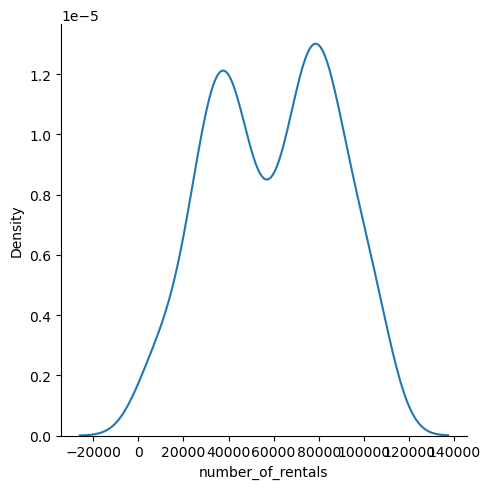

In [39]:
print(train1['number_of_rentals'].skew())
sns.displot(data=train1, x='number_of_rentals', kind="kde")

In [40]:
train1['number_of_rentals'].kurt()

-1.0376478450161055

In [41]:
train1.columns

Index(['date_time', 'year', 'month', 'day', 'weekday', 'monthday',
       'wind_direction', 'wind_speed', 'sky_condition', 'precipitation_form',
       'Precipitation_Probability', 'humidity', 'low_temp', 'high_temp',
       'temp_diff', 'med_temp', 'discomf', 'number_of_rentals'],
      dtype='object')

# Ensemble

In [42]:
data = train1[['year', 'month', 'day', 'weekday', 
       'wind_direction', 'wind_speed', 'sky_condition', 'precipitation_form',
       'Precipitation_Probability', 'humidity', 'low_temp', 'high_temp',
       'temp_diff', 'med_temp', 'discomf', 'number_of_rentals']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       271 non-null    int64  
 1   month                      271 non-null    int64  
 2   day                        271 non-null    int64  
 3   weekday                    271 non-null    int64  
 4   wind_direction             271 non-null    float64
 5   wind_speed                 271 non-null    float64
 6   sky_condition              271 non-null    float64
 7   precipitation_form         271 non-null    float64
 8   Precipitation_Probability  271 non-null    float64
 9   humidity                   271 non-null    float64
 10  low_temp                   271 non-null    float64
 11  high_temp                  271 non-null    float64
 12  temp_diff                  271 non-null    float64
 13  med_temp                   271 non-null    float64

In [43]:
Y = data.pop('number_of_rentals')
X = data

c:\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


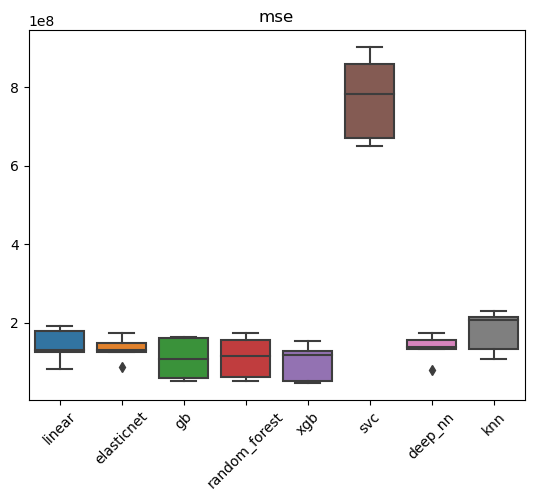

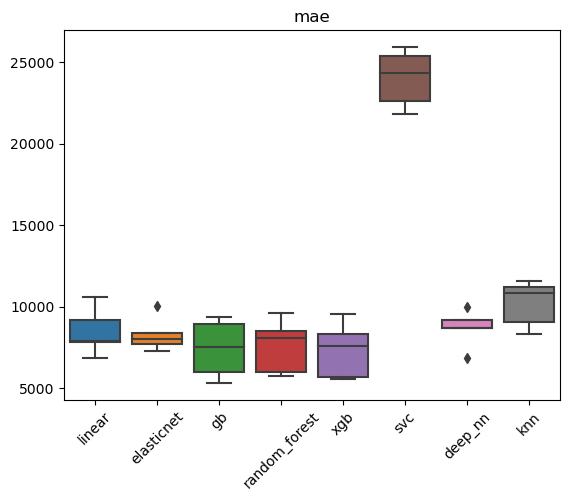

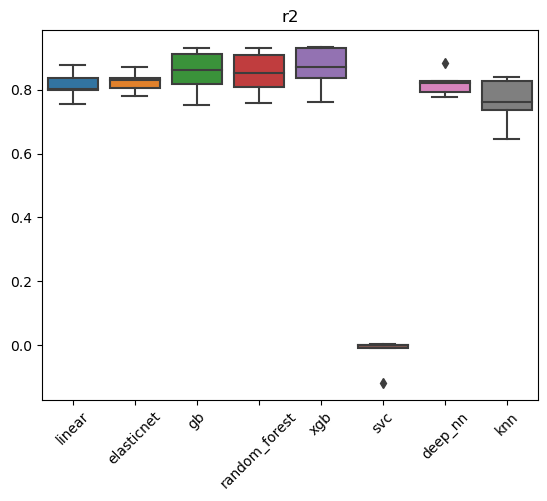

In [44]:
from sklearn.model_selection import train_test_split
data, eval_data, target, eval_target = train_test_split(X,Y,test_size=.20)
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

estimators=[
    ('linear',LinearRegression()),
    ('elasticnet',SGDRegressor(penalty='elasticnet')),
    ('gb',GradientBoostingRegressor(n_estimators=200, learning_rate=0.05,
                                   max_depth=7, min_samples_leaf=15, min_samples_split=10)),
    ('random_forest',RandomForestRegressor()),
    ('xgb',XGBRegressor(n_estimators=100, learning_rate=0.05, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)),
    ('svc',SVR(C=10, epsilon=0.2, kernel='rbf')), #Radial Basis Function
    ('deep_nn',MLPRegressor(hidden_layer_sizes=(512,256,128,100,100,64,32,16,8), alpha=0.005, random_state=42, activation='identity')),
    ('knn',KNeighborsRegressor(n_neighbors=5,weights='distance',algorithm='auto'))
]

pipes={}
for model in estimators:
    pipe=Pipeline(steps=[('scaler',StandardScaler()), model])
    pipe.fit(data,target)
    pipes[pipe.steps[1][0]]=pipe
### Initial Model Scoring
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

_metrics={'mse':make_scorer(mean_squared_error),'mae':make_scorer(mean_absolute_error),'r2':make_scorer(r2_score)} # 'msle':make_scorer(mean_squared_log_error),

estimator_names=[model[0] for model in estimators]

def plot_estimators(estimators=estimator_names,n_splits=5,metrics=['mse','mae','r2']):
    metrics={key : _metrics[key] for key in metrics}
    scorers=[]
    labels=[]
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe=pipes[pipe_name]
            labels.append(pipe_name)
            kf=KFold(n_splits)
            model_score=cross_validate(pipe,data,target,scoring=metrics,cv=kf)
            scorers.append(model_score)
    
    score_lists={}
    for metric in metrics:
        score_lists[metric]=[score['test_'+metric] for score in scorers]
    
    for  i,(title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)
metrics={'mse':make_scorer(mean_squared_error),'mae':make_scorer(mean_absolute_error),'r2':make_scorer(r2_score)}
plot_estimators()

In [45]:
#tuning해도 성능개선 안되는 svc drop
del pipes['svc'] 

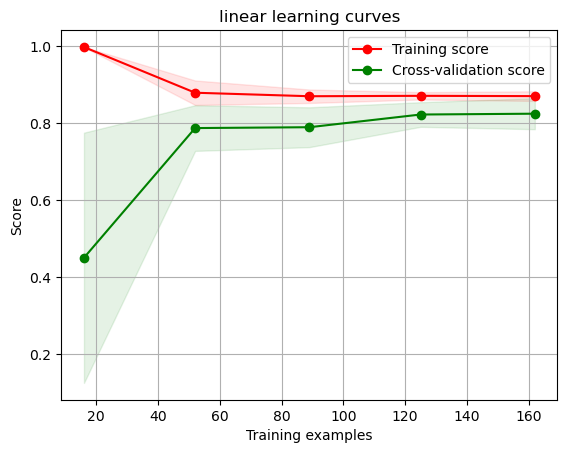

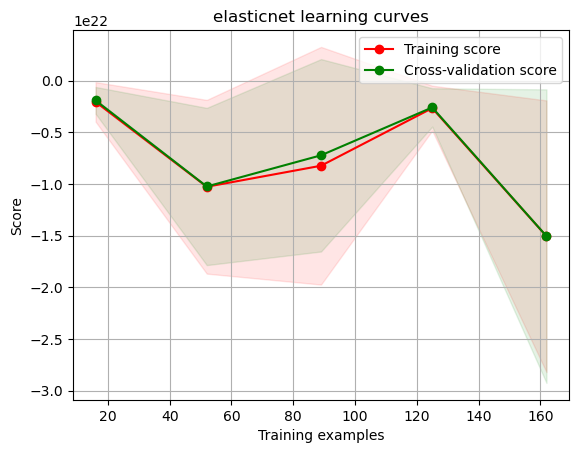

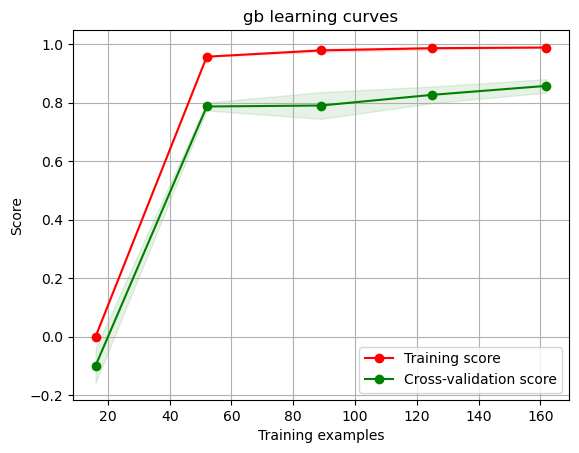

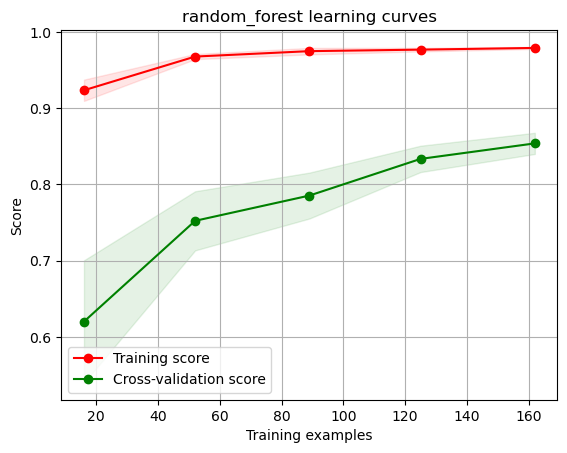

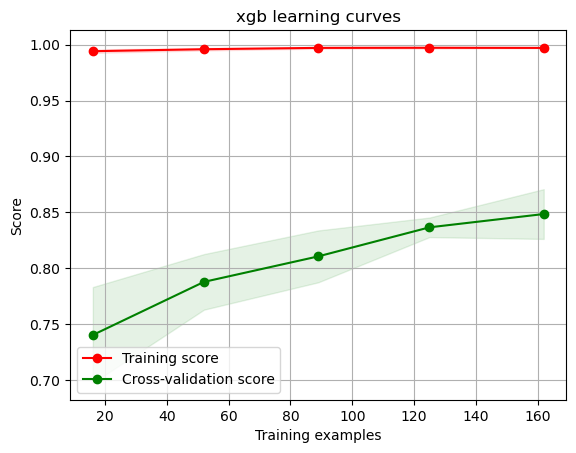

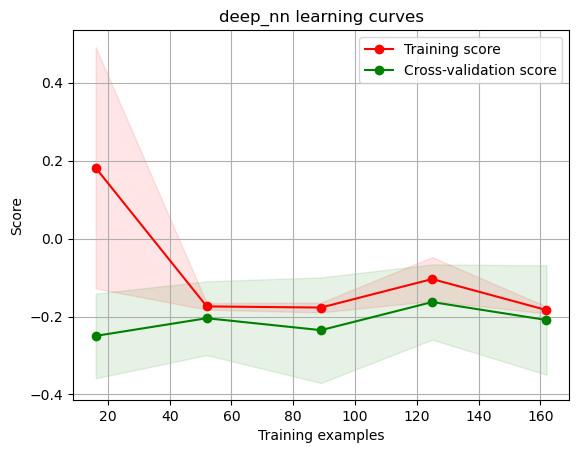

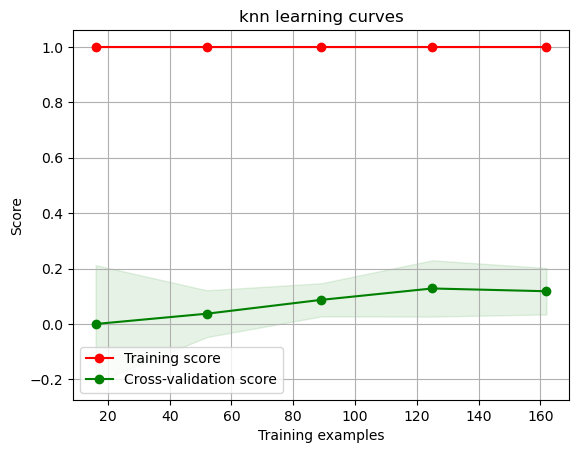

In [46]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

to_plot=['linear','elasticnet','gb','random_forest','xgb','deep_nn','knn']
for name in pipes.keys():
    if name in to_plot:
        g=plot_learning_curve(pipes[name].named_steps[name],name+' learning curves',data,target,cv=KFold(4),n_jobs=4)

In [48]:
def print_predictions(target,predictions):
    print('mean_absolute_error: '+str(mean_absolute_error(target,predictions)))
    print('mean_squared_error: '+str(mean_squared_error(target,predictions)))
    print('r2_score: '+str(r2_score(target,predictions)))

In [49]:
from sklearn.ensemble import VotingRegressor
from sklearn.base import clone

estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipes.values()] 
vote=Pipeline(steps=[('scaler',StandardScaler()), ('voter',VotingRegressor(estimators))])
vote.fit(data,target)
predictions=vote.predict(eval_data)

print_predictions(eval_target,predictions)

mean_absolute_error: 7295.560353309763
mean_squared_error: 101430278.3664089
r2_score: 0.8589186246182441


In [50]:
for name in pipes.keys():
    print(name)
    predictions=pipes[name].predict(eval_data)
    print_predictions(eval_target,predictions)
    print()

linear
mean_absolute_error: 8031.341199706022
mean_squared_error: 114958262.28707124
r2_score: 0.8401022848782027

elasticnet
mean_absolute_error: 8216.047770239313
mean_squared_error: 123204646.10477652
r2_score: 0.8286322269264244

gb
mean_absolute_error: 7910.186695846918
mean_squared_error: 126528087.05039747
r2_score: 0.8240095873442429

random_forest
mean_absolute_error: 7822.332181818183
mean_squared_error: 130187985.14591819
r2_score: 0.8189189628740242

xgb
mean_absolute_error: 6869.181676136363
mean_squared_error: 83842426.77677141
r2_score: 0.8833819143995527

deep_nn
mean_absolute_error: 9067.077594086588
mean_squared_error: 136750843.1916892
r2_score: 0.8097905541341027

knn
mean_absolute_error: 11047.946558595131
mean_squared_error: 186205011.51392835
r2_score: 0.7410037756924792



In [51]:
del pipes['knn'], pipes['elasticnet'], pipes['deep_nn']

In [52]:
from itertools import combinations

final_estimators=pipes.keys()

combos=[]
for L in range(2, len(final_estimators)+1):
    for subset in combinations(final_estimators, L):
        combos.append(list(subset))


combo_names=[]
mae=[]
mse=[]
r2=[]

for combo in combos:
    estimators=[(name,clone(pipes[name].named_steps[name])) for name in combo] 
    vote=Pipeline(steps=[('scaler',StandardScaler()), ('voter',VotingRegressor(estimators))])
    vote.fit(data,target)
    predictions=vote.predict(eval_data)

    mae.append(mean_absolute_error(eval_target,predictions))
    mse.append(mean_squared_error(eval_target,predictions))
    r2.append(r2_score(eval_target,predictions))
    combo_names.append(str(list(combo)))
    
score=pd.DataFrame()
score['combo']=combo_names
score['mae']=mae
score['mse']=mse
score['r2']=r2

score

,combo,mae,mse,r2
0,"['linear', 'gb']",7255.314432,1.057882e+08,0.852857
1,"['linear', 'random_forest']",7235.765039,1.077471e+08,0.850132
2,"['linear', 'xgb']",6721.908873,8.738688e+07,0.878452
3,"['gb', 'random_forest']",7716.622014,1.262319e+08,0.824422
4,"['gb', 'xgb']",7015.753209,9.875390e+07,0.862641
5,"['random_forest', 'xgb']",7351.049020,1.037375e+08,0.855709
6,"['linear', 'gb', 'random_forest']",7271.491806,1.090995e+08,0.848251
7,"['linear', 'gb', 'xgb']",6920.349305,9.380280e+07,0.869528
8,"['linear', 'random_forest', 'xgb']",7066.104363,9.746225e+07,0.864438
9,"['gb', 'random_forest', 'xgb']",7289.469781,1.054171e+08,0.853373


# Final Test

최종: 	['linear', 'gb', 'random_forest', 'xgb']

In [53]:
final_estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipes.values()] 
final_vote=Pipeline(steps=[('scaler',StandardScaler()), ('voter',VotingRegressor(final_estimators))])
final_vote.named_steps

{'scaler': StandardScaler(),
 'voter': VotingRegressor(estimators=[('linear', LinearRegression()),
                             ('gb',
                              GradientBoostingRegressor(learning_rate=0.05,
                                                        max_depth=7,
                                                        min_samples_leaf=15,
                                                        min_samples_split=10,
                                                        n_estimators=200)),
                             ('random_forest', RandomForestRegressor()),
                             ('xgb',
                              XGBRegressor(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorica...
                                           gpu_i

In [54]:
final_vote.fit(data,target)
predictions=final_vote.predict(eval_data)

print_predictions(eval_target,predictions)

mean_absolute_error: 7000.810481146309
mean_squared_error: 97525335.21007174
r2_score: 0.8643500870982491


In [55]:
print('NMAE: ',NMAE(eval_target,predictions))
print('RMAE: ',np.sqrt(7124.523835369308))
print('RMSE: ',np.sqrt(92937607.32966764))
print('r2_score: 0.8828957640545566')

NMAE:  0.20507029592246004
RMAE:  84.40689447769837
RMSE:  9640.415308982681
r2_score: 0.8828957640545566


In [56]:
test1=test.drop(['date_time', 'monthday'],axis=1)
test1.tail(3)

,year,month,day,weekday,wind_direction,wind_speed,sky_condition,precipitation_form,Precipitation_Probability,humidity,low_temp,high_temp,temp_diff,med_temp,discomf
88,2021,6,28,0,111.095,1.692,3.338,1.270,35.946,70.338,21.0,28.789,7.789,24.8945,73.741401
89,2021,6,29,1,171.622,1.470,3.270,0.595,27.770,70.473,21.0,29.421,8.421,25.2105,74.231796
90,2021,6,30,2,181.709,1.180,3.270,0.703,29.054,75.203,21.5,30.211,8.711,25.8555,75.738597


In [57]:
final_vote.fit(X,Y)
pred = final_vote.predict(test1)
submission = pd.read_csv('./sample_submission.csv')
submission['number_of_rentals'] = pred
submission

,date_time,number_of_rentals
0,2021-04-01,76029.749659
1,2021-04-02,65502.901848
2,2021-04-03,45101.797472
3,2021-04-04,47803.241013
4,2021-04-05,83578.961765
...,...,...
86,2021-06-26,98406.380272
87,2021-06-27,104422.195756
88,2021-06-28,79838.006782
89,2021-06-29,84843.507640


In [58]:
submission.to_csv('./sample_submission.csv', index=False)

# SARIMAX(0.1624851686378917)의 성능이 ENSEMBLE(0.20507029592246004)보다 낫게 나타남